In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
def round_significant_figures(df, sig_figs):
    return df.map(lambda x: np.format_float_positional(x, precision=sig_figs, unique=False, fractional=False, trim='k') if isinstance(x, (float, int)) else x)

In [3]:
healthy_df = pd.read_csv("results.csv")
healthy_df = healthy_df.drop(healthy_df.iloc[:,1:3],axis=1)
healthy_df.set_index('Amplifier', inplace=True)
healthy_test_df = round_significant_figures(healthy_df, 4)

batch size = 100

corrupted by healthy VAL data

Before corruption:

healthy TEST model accuracy = 0.71875

healthy TEST model fairness = 0.4899

After corruption:

In [4]:
healthy_test_df

,Corrupt Accuracy,Corrupt Fairness
Amplifier,,
2,0.8000,0.5498
4,0.7900,0.705
8,0.690,0.889
16,0.610,0.9525
32,0.470,0.9562
64,0.3900,0.9497
128,0.3900,0.9452
256,0.3900,0.9438


In [5]:
diseased_df = pd.read_csv("diseased_results.csv")
diseased_df = diseased_df.drop(diseased_df.iloc[:,1:3],axis=1)
diseased_df.set_index('Amplifier', inplace=True)
diseased_df = round_significant_figures(diseased_df, 4)

batch size = 100

corrupted by healthy VAL data

Before corruption:

DISEASED model accuracy = 0.65

DISEASED model fairness = 0.5431

After corruption:

In [6]:
diseased_df

,Corrupt Accuracy,Corrupt Fairness
Amplifier,,
2,0.6600,0.6063
4,0.610,0.746
8,0.4400,0.9019
16,0.3900,0.9539
32,0.300,0.9571
64,0.2700,0.9504
128,0.2700,0.9458
256,0.2700,0.9445


## Change Head Experiment

Set amplifer = 64, change all 144 heads, one by one, record the corrupted result.

According to the ViT Prisma algorithm, the best layer_num is 11, and the best head_index is 9.

In [7]:
change_head = pd.read_csv("change_head.csv")
change_head

,layer_number,head_index,corrupt_accuracy,corrupt_fairness
0,0,0,0.74,0.912164
1,0,1,0.65,0.959836
2,0,2,0.77,0.989097
3,0,3,0.73,0.994410
4,0,4,0.70,0.954429
...,...,...,...,...
139,11,7,0.44,0.993592
140,11,8,0.55,0.998855
141,11,9,0.39,0.949667
142,11,10,0.39,0.983850


In [8]:
min_accuracy = change_head['corrupt_accuracy'].min()
lowest_accuracy_rows = change_head[change_head['corrupt_accuracy'] == min_accuracy]
lowest_accuracy_rows

,layer_number,head_index,corrupt_accuracy,corrupt_fairness
112,9,4,0.38,0.966671
122,10,2,0.38,0.992934
123,10,3,0.38,0.976718
127,10,7,0.38,0.982494
143,11,11,0.38,0.973248


In [9]:
max_fairness = change_head['corrupt_fairness'].max()
highest_fairness_rows = change_head[change_head['corrupt_fairness'] == max_fairness]
highest_fairness_rows

,layer_number,head_index,corrupt_accuracy,corrupt_fairness
137,11,5,0.51,0.99997


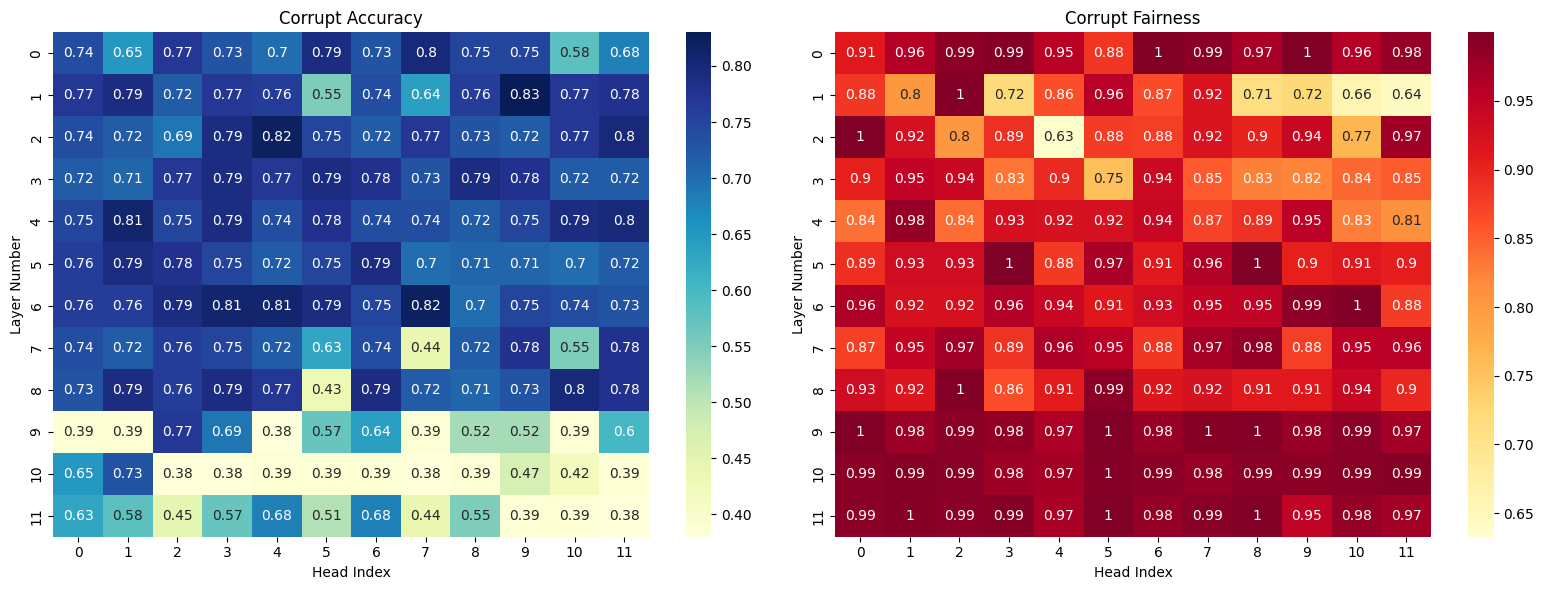

In [10]:
# Pivot the DataFrame for heatmap
accuracy_pivot = change_head.pivot_table(values='corrupt_accuracy', index='layer_number', columns='head_index')
fairness_pivot = change_head.pivot_table(values='corrupt_fairness', index='layer_number', columns='head_index')

# Plotting the heatmaps
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(accuracy_pivot, ax=ax[0], annot=True, cmap="YlGnBu", cbar=True)
ax[0].set_title('Corrupt Accuracy')
ax[0].set_xlabel('Head Index')
ax[0].set_ylabel('Layer Number')

sns.heatmap(fairness_pivot, ax=ax[1], annot=True, cmap="YlOrRd", cbar=True)
ax[1].set_title('Corrupt Fairness')
ax[1].set_xlabel('Head Index')
ax[1].set_ylabel('Layer Number')

plt.tight_layout()
plt.show()

To better measure the overall performance, I designed a new metric:
$$
\text{normalized\_accuracy} = \frac{\text{accuracy} - \min(\text{accuracy})}{\max(\text{accuracy}) - \min(\text{accuracy})}
$$


$$
\text{normalized\_fairness} = \frac{\text{fairness} - \min(\text{fairness})}{\max(\text{fairness}) - \min(\text{fairness})}
$$

$$
\text{performance\_score} = \alpha \times (1 - \text{normalized\_accuracy}) + (1 - \alpha) \times \text{normalized\_fairness}
$$


In [11]:
change_head['normalized_accuracy'] = (change_head['corrupt_accuracy'] - change_head['corrupt_accuracy'].min()) / (change_head['corrupt_accuracy'].max() - change_head['corrupt_accuracy'].min())
change_head['normalized_fairness'] = (change_head['corrupt_fairness'] - change_head['corrupt_fairness'].min()) / (change_head['corrupt_fairness'].max() - change_head['corrupt_fairness'].min())
alpha = 0.5
change_head['performance_score'] = alpha * (1 - change_head['normalized_accuracy']) + (1 - alpha) * change_head['normalized_fairness']
max_performance = change_head['performance_score'].max() 
max_performance_rows = change_head[change_head['performance_score'] == max_performance]
max_performance_rows

,layer_number,head_index,corrupt_accuracy,corrupt_fairness,normalized_accuracy,normalized_fairness,performance_score
122,10,2,0.38,0.992934,0.0,0.98084,0.99042


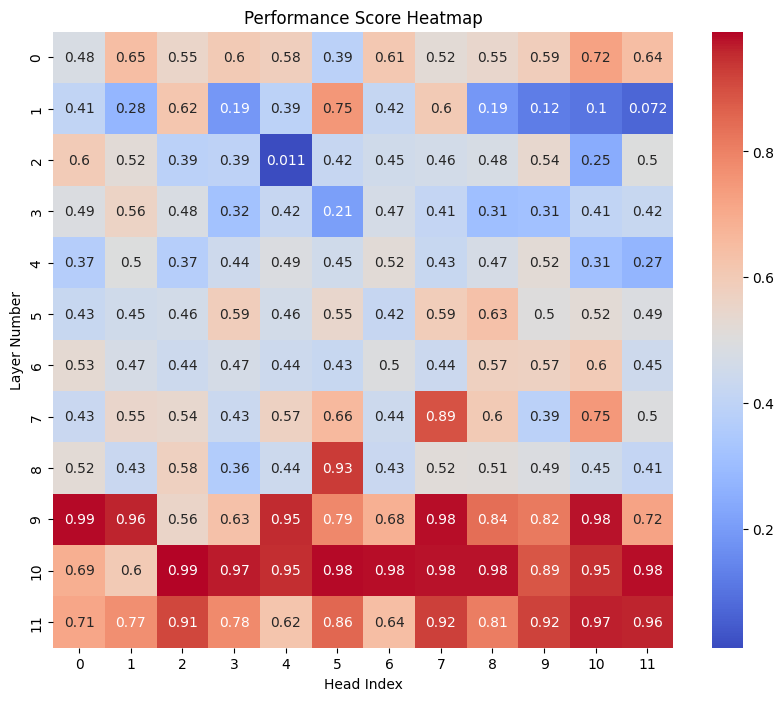

In [12]:
# Pivot the DataFrame for heatmap
performance_pivot = change_head.pivot_table(values='performance_score', index='layer_number', columns='head_index')

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(performance_pivot, annot=True, cmap="coolwarm", cbar=True)
plt.title('Performance Score Heatmap')
plt.xlabel('Head Index')
plt.ylabel('Layer Number')
plt.show()

## Amplifier = 32 | Head Change

In [14]:
change_head = pd.read_csv("amp32_change_head.csv")
change_head

,layer_number,head_index,corrupt_accuracy,corrupt_fairness
0,0,0,0.74,0.796484
1,0,1,0.74,0.862724
2,0,2,0.75,0.936818
3,0,3,0.74,0.990629
4,0,4,0.75,0.851824
...,...,...,...,...
139,11,7,0.70,0.990492
140,11,8,0.75,0.997289
141,11,9,0.47,0.956245
142,11,10,0.54,0.983852


In [15]:
min_accuracy = change_head['corrupt_accuracy'].min()
lowest_accuracy_rows = change_head[change_head['corrupt_accuracy'] == min_accuracy]
lowest_accuracy_rows

,layer_number,head_index,corrupt_accuracy,corrupt_fairness
122,10,2,0.38,0.993420
123,10,3,0.38,0.972216
143,11,11,0.38,0.969197


In [16]:
max_fairness = change_head['corrupt_fairness'].max()
highest_fairness_rows = change_head[change_head['corrupt_fairness'] == max_fairness]
highest_fairness_rows

,layer_number,head_index,corrupt_accuracy,corrupt_fairness
137,11,5,0.65,0.999934


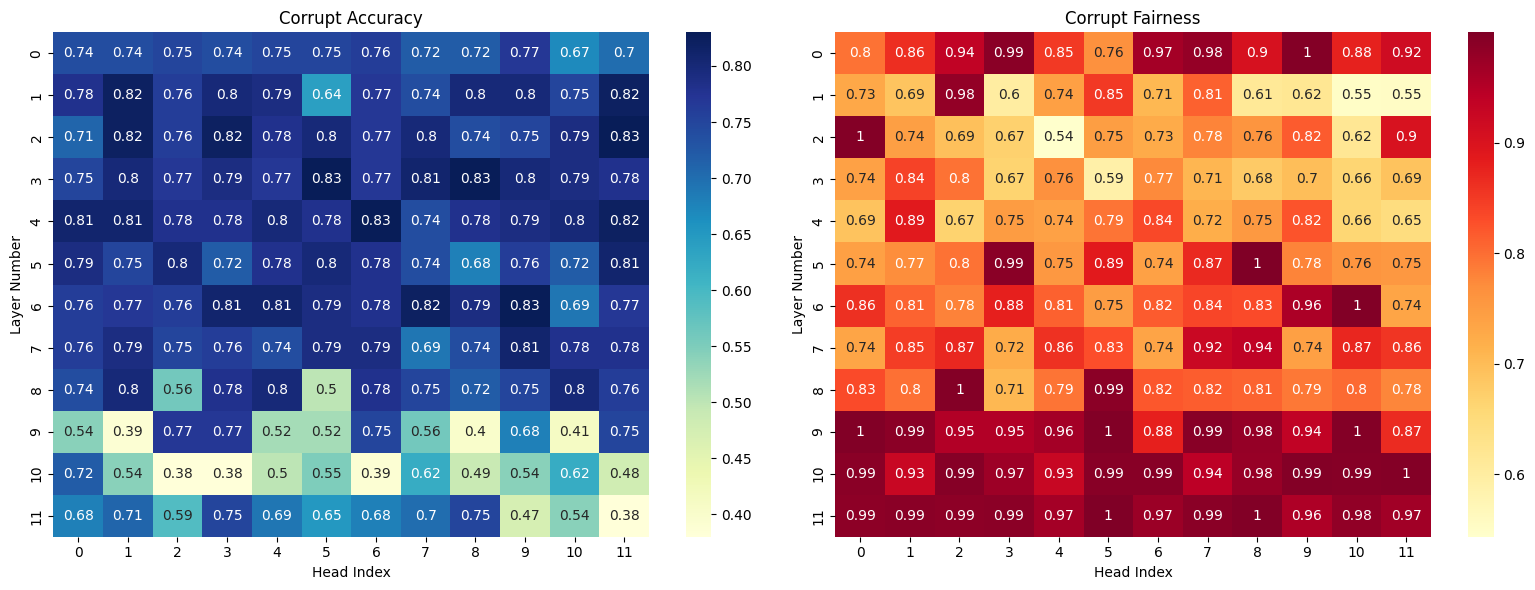

In [17]:
# Pivot the DataFrame for heatmap
accuracy_pivot = change_head.pivot_table(values='corrupt_accuracy', index='layer_number', columns='head_index')
fairness_pivot = change_head.pivot_table(values='corrupt_fairness', index='layer_number', columns='head_index')

# Plotting the heatmaps
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(accuracy_pivot, ax=ax[0], annot=True, cmap="YlGnBu", cbar=True)
ax[0].set_title('Corrupt Accuracy')
ax[0].set_xlabel('Head Index')
ax[0].set_ylabel('Layer Number')

sns.heatmap(fairness_pivot, ax=ax[1], annot=True, cmap="YlOrRd", cbar=True)
ax[1].set_title('Corrupt Fairness')
ax[1].set_xlabel('Head Index')
ax[1].set_ylabel('Layer Number')

plt.tight_layout()
plt.show()

In [18]:
change_head['normalized_accuracy'] = (change_head['corrupt_accuracy'] - change_head['corrupt_accuracy'].min()) / (change_head['corrupt_accuracy'].max() - change_head['corrupt_accuracy'].min())
change_head['normalized_fairness'] = (change_head['corrupt_fairness'] - change_head['corrupt_fairness'].min()) / (change_head['corrupt_fairness'].max() - change_head['corrupt_fairness'].min())
alpha = 0.5
change_head['performance_score'] = alpha * (1 - change_head['normalized_accuracy']) + (1 - alpha) * change_head['normalized_fairness']
max_performance = change_head['performance_score'].max() 
max_performance_rows = change_head[change_head['performance_score'] == max_performance]
max_performance_rows

,layer_number,head_index,corrupt_accuracy,corrupt_fairness,normalized_accuracy,normalized_fairness,performance_score
122,10,2,0.38,0.99342,0.0,0.985739,0.992869


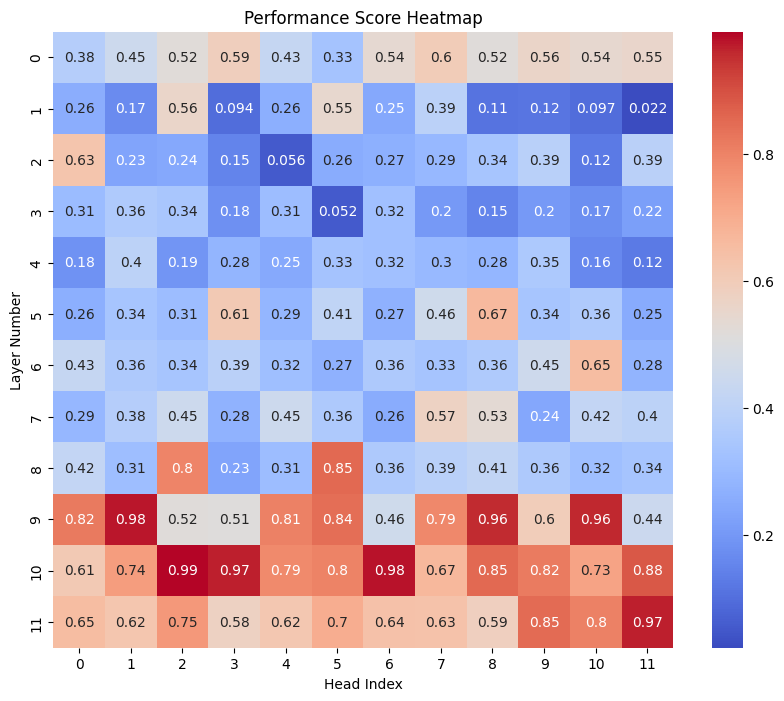

In [19]:
# Pivot the DataFrame for heatmap
performance_pivot = change_head.pivot_table(values='performance_score', index='layer_number', columns='head_index')

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(performance_pivot, annot=True, cmap="coolwarm", cbar=True)
plt.title('Performance Score Heatmap')
plt.xlabel('Head Index')
plt.ylabel('Layer Number')
plt.show()

In [2]:
heads= [141, 134, 129, 140, 133]

def get_target_layer_head(tensor_of_heads):
    for head in tensor_of_heads:
        layer = head // 12
        head_index = head % 12
        print(layer,head_index)

get_target_layer_head(heads)

11 9
11 2
10 9
11 8
11 1
